In [1]:
import random, os, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

# Define architecture

In [2]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(0)

In [3]:
class BaseVAE(nn.Module):
    def __init__(self, seq_len, feat_dim, latent_dim, device="cuda", kl_weight=1.0, lr=1e-5):
        '''
            Inputs:
                seq_len: the time series sequence length
                feat_dim: the feature dimension of each time step, integer if 1D, tuple of integers if 2D
                kl_weight: weight \beta used for loss = RE + \beta * KL
                lr: learning rate for weighted Adam in training
        '''
        super(BaseVAE, self).__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.lr = lr

        self.device = device
    
    def encode(self, x):
        raise NotImplementedError()

    def decode(self, x):
        raise NotImplementedError()

    def forward(self, x):
        z_mean, _, _ = self.encode(x)
        x_decoded = self.decode(z_mean)
        return x_decoded
    
    def count_parameters(self):
        modules = []
        params = []
        total_params = 0
        for name, parameter in self.named_parameters():
            if not parameter.requires_grad: 
                continue
            p_count = parameter.numel()
            modules.append(name)
            params.append(p_count)
            total_params += p_count
        modules.append("Total")
        params.append(total_params)
        df = pd.DataFrame({"module": modules, "num_params": params})
        return df
    
    def get_prior_samples(self, num_samples):
        z = torch.randn((num_samples, self.latent_dim)).to(self.device)
        samples = self.decode(z)
        return samples
    
    def get_prior_samples_given_z(self, z):
        z = z.to(self.device)
        return self.decode(z)
    
    def train_step(self, x):
        x = x.to(self.device)
        self.optimizer.zero_grad()
        z_mean, z_log_var, z = self.encode(x)
        reconstruction = self.decode(z)

        # RE = 1/M \sum_{i=1}^M (x_i - y_i)^2
        reconstruction_error = F.mse_loss(reconstruction, x)
        # KL = -1/2 \sum_{i=1}^M (1+log(\sigma_k^2) - \sigma_k^2 - \mu_k^2)
        kl_loss = -0.5 * (1 + z_log_var - torch.exp(z_log_var) - torch.square(z_mean))
        kl_loss = torch.mean(torch.sum(kl_loss, dim=1))
        total_loss = reconstruction_error + self.kl_weight * kl_loss
        total_loss.backward()
        self.optimizer.step()

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_error,
            "kl_loss": kl_loss,
        }
    
    def test_step(self, x):
        x = x.to(self.device)
        z_mean, z_log_var, z = self.encode(x)
        reconstruction = self.decode(z)

        # RE = 1/M \sum_{i=1}^M (x_i - y_i)^2
        reconstruction_error = F.mse_loss(reconstruction, x)
        # KL = -1/2 \sum_{i=1}^M (1+log(\sigma_k^2) - \sigma_k^2 - \mu_k^2)
        kl_loss = -0.5 * (1 + z_log_var - torch.exp(z_log_var) - torch.square(z_mean))
        kl_loss = torch.mean(torch.sum(kl_loss, dim=1))
        total_loss = reconstruction_error + self.kl_weight * kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_error,
            "kl_loss": kl_loss,
        }

    def save_weights(self, model_dir, file_prefix):
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(self.state_dict(), f"{model_dir}/{file_prefix}_weights.pt")
    
    def load_weights(self, model_dir, file_prefix):
        self.load_state_dict(torch.load(f"{model_dir}/{file_prefix}_weights.pt"))

In [4]:
x = torch.randn((2, 3, 5, 5))
print(x.shape)
y = torch.flatten(x, 1, -1)
print(y.shape)

torch.Size([2, 3, 5, 5])
torch.Size([2, 75])


In [5]:
class VAEDense(BaseVAE):
    def __init__(self, seq_len, feat_dim, latent_dim, device="cuda", kl_weight=1, lr=0.00001, 
                 hidden_layer_sizes=[100]):
        super().__init__(seq_len, feat_dim, latent_dim, device, kl_weight, lr)
        self.hidden_layer_sizes = hidden_layer_sizes

        # encoder
        encoder_layers = OrderedDict()
        # flatten the feature dimension seq_len * feat_dim
        encoder_layers["flatten"] = nn.Flatten()
        if isinstance(self.feat_dim, tuple):
            self.flattened_dim = self.seq_len * self.feat_dim[0] * self.feat_dim[1]
        else:
            self.flattened_dim = self.seq_len * self.feat_dim
        in_feats = self.flattened_dim
        for i, out_feats in enumerate(self.hidden_layer_sizes):
            encoder_layers[f"enc_dense_{i}"] = nn.Linear(in_feats, out_feats)
            encoder_layers[f"enc_activation_{i}"] = nn.ReLU()
            in_feats = out_feats
        self.encoder_dense = nn.Sequential(encoder_layers)
        self.z_mean_layer = nn.Linear(in_feats, self.latent_dim)
        self.z_log_var_layer = nn.Linear(in_feats, self.latent_dim)

        # decoder
        decoder_layers = OrderedDict()
        in_feats = self.latent_dim
        for i, out_feats in enumerate(reversed(self.hidden_layer_sizes)):
            decoder_layers[f"dec_dense_{i}"] = nn.Linear(in_feats, out_feats)
            decoder_layers[f"dec_activation_{i}"] = nn.ReLU()
            in_feats = out_feats
        decoder_layers[f"dec_output"] = nn.Linear(in_feats, self.flattened_dim)
        self.decoder_dense = nn.Sequential(decoder_layers)
        self.to(self.device)
        self.optimizer = opt.AdamW(self.parameters(), lr)

    def encode(self, x):
        x = self.encoder_dense(x)
        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        eps = torch.rand_like(z_log_var)
        z = z_mean + torch.exp(0.5 * z_log_var) * eps
        return (z_mean, z_log_var, z)
    
    def decode(self, x):
        out = self.decoder_dense(x)
        if isinstance(self.feat_dim, tuple):
            out = out.view((-1, self.seq_len, self.feat_dim[0], self.feat_dim[1]))
        else:
            out = out.view((-1, self.seq_len, self.feat_dim))
        return out

In [6]:
class VAEConv2D(BaseVAE):
    def __init__(self, seq_len, feat_dim, latent_dim, device="cuda", kl_weight=1, lr=0.00001,
                 hidden_layer_sizes=[100]):
        '''
            The input size should be BxTx5x5, sequence length will be used as the C channel
            Idea from: https://github.com/AntixK/PyTorch-VAE
        '''
        super().__init__(seq_len, feat_dim, latent_dim, device, kl_weight, lr)
        self.hidden_layer_sizes = hidden_layer_sizes

        # we want to keep the dimensions the same, out_dim = (in_dim - kernel_size + 2*padding) / stride + 1
        # so padding = (out_dim * stride + kernel_size - in_dim) // 2 where in_dim and out_dim are 5
        padding = ((feat_dim[-1] - 1) * 2 + 3 - feat_dim[-1]) // 2
        if ((feat_dim[-1] - 1) * 2 + 3 - feat_dim[-1]) % 2 == 1:
            padding1 = padding + 1
            deconv_output_padding = 1
        else:
            padding1 = padding
            deconv_output_padding = 0
        
        # encoder
        encoder_layers = OrderedDict()
        in_feats = self.seq_len
        for i, out_feats in enumerate(self.hidden_layer_sizes):
            
            encoder_layers[f"enc_conv_{i}"] = nn.Conv2d(
                in_feats, out_feats,
                kernel_size=3, stride=2, padding=padding1,
            )
            encoder_layers[f"enc_activation_{i}"] = nn.ReLU()
            in_feats = out_feats
        encoder_layers["flatten"] = nn.Flatten()
        self.encoder_conv = nn.Sequential(encoder_layers)
        self.z_mean_layer = nn.Linear(in_feats*feat_dim[0]*feat_dim[1], self.latent_dim)
        self.z_log_var_layer = nn.Linear(in_feats*feat_dim[0]*feat_dim[1], self.latent_dim)

        # decoder
        self.decoder_input = nn.Linear(self.latent_dim, in_feats*feat_dim[0]*feat_dim[1])
        decoder_layers = OrderedDict()
        for i, out_feats in enumerate(reversed(self.hidden_layer_sizes[:-1])):
            decoder_layers[f"dec_deconv_{i}"] = nn.ConvTranspose2d(
                in_feats, out_feats,
                kernel_size=3, stride=2, padding=padding1, output_padding=deconv_output_padding,
                )
            decoder_layers[f"dec_activation_{i}"] = nn.ReLU()
            in_feats = out_feats
        
        # transform to the original size
        decoder_layers["dec_final"] = nn.ConvTranspose2d(
            in_feats, in_feats,
            kernel_size=3, stride=2, padding=padding1, output_padding=deconv_output_padding,
        )
        decoder_layers["dec_final_activation"] = nn.ReLU()
        decoder_layers["dec_output"] = nn.Conv2d(
            in_feats, self.seq_len,
            kernel_size=3, padding="same"
        )
        self.decoder_layers = nn.Sequential(decoder_layers)
        self.to(self.device)
        self.optimizer = opt.AdamW(self.parameters(), lr)
    
    def encode(self, x):
        '''
            Input:
                x should be of shape BxTx5x5
        '''
        x = self.encoder_conv(x) # Bx(hidden[-1]x5x5)
        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        eps = torch.rand_like(z_log_var)
        z = z_mean + torch.exp(0.5 * z_log_var) * eps
        return (z_mean, z_log_var, z)
    
    def decode(self, x):
        '''
            Input:
                x should be of shape Bxlatent dim
        '''
        x = self.decoder_input(x) # Bx(hidden[-1]x5x5)
        x = x.view(-1, self.hidden_layer_sizes[-1], self.feat_dim[0], self.feat_dim[1])
        out = self.decoder_layers(x)
        return out

In [7]:
dense_model = VAEDense(3, (5,5), 10, hidden_layer_sizes=[50, 100])
print(dense_model)

VAEDense(
  (encoder_dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (enc_dense_0): Linear(in_features=75, out_features=50, bias=True)
    (enc_activation_0): ReLU()
    (enc_dense_1): Linear(in_features=50, out_features=100, bias=True)
    (enc_activation_1): ReLU()
  )
  (z_mean_layer): Linear(in_features=100, out_features=10, bias=True)
  (z_log_var_layer): Linear(in_features=100, out_features=10, bias=True)
  (decoder_dense): Sequential(
    (dec_dense_0): Linear(in_features=10, out_features=100, bias=True)
    (dec_activation_0): ReLU()
    (dec_dense_1): Linear(in_features=100, out_features=50, bias=True)
    (dec_activation_1): ReLU()
    (dec_output): Linear(in_features=50, out_features=75, bias=True)
  )
)


In [8]:
x = torch.randn((2, 3, 5, 5))
dense_model.train_step(x)

{'loss': tensor(1.1537, device='cuda:0', grad_fn=<AddBackward0>),
 'reconstruction_loss': tensor(1.0339, device='cuda:0', grad_fn=<MseLossBackward0>),
 'kl_loss': tensor(0.1198, device='cuda:0', grad_fn=<MeanBackward0>)}

In [9]:
conv2d_model = VAEConv2D(3, (5, 5), 10, hidden_layer_sizes=[50, 100])
print(conv2d_model)

VAEConv2D(
  (encoder_conv): Sequential(
    (enc_conv_0): Conv2d(3, 50, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (enc_activation_0): ReLU()
    (enc_conv_1): Conv2d(50, 100, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (enc_activation_1): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean_layer): Linear(in_features=2500, out_features=10, bias=True)
  (z_log_var_layer): Linear(in_features=2500, out_features=10, bias=True)
  (decoder_input): Linear(in_features=10, out_features=2500, bias=True)
  (decoder_layers): Sequential(
    (dec_deconv_0): ConvTranspose2d(100, 50, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (dec_activation_0): ReLU()
    (dec_final): ConvTranspose2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (dec_final_activation): ReLU()
    (dec_output): Conv2d(50, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
)


In [10]:
x = torch.randn((2, 3, 5, 5))
conv2d_model.train_step(x)

{'loss': tensor(1.0032, device='cuda:0', grad_fn=<AddBackward0>),
 'reconstruction_loss': tensor(0.9951, device='cuda:0', grad_fn=<MseLossBackward0>),
 'kl_loss': tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)}

# Create dataset

In [11]:
data = np.load("data/vol_surface.npy")
print(data.shape)

(5532, 5, 5)


In [12]:
class VolSurfaceDataSet(Dataset):
    def __init__(self, dataset, seq_len):
        self.dataset = torch.from_numpy(dataset).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.dataset) - self.seq_len + 1

    def __getitem__(self, idx):
        ele = self.dataset[idx:idx+self.seq_len]
        return ele

In [13]:
train_dataset = VolSurfaceDataSet(data[:5000], 1)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
print(len(train_dataset))
print(next(iter(train_dataset)).shape)

5000
torch.Size([1, 5, 5])


In [14]:
train_dataset = VolSurfaceDataSet(data[:5000], 3)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
print(len(train_dataset))
print(next(iter(train_dataset)).shape)

4998
torch.Size([3, 5, 5])


# Training and testing

In [15]:
# perform model evaluation in terms of the accuracy and f1 score.
def model_eval(model: BaseVAE, dataloader):
    model.eval() # switch to eval model, will turn off randomness like dropout
    eval_loss = 0
    num_batches = 0
    for step, batch in enumerate(tqdm(dataloader, desc=f"eval")):
        batch.to(model.device)

        losses = model.test_step(batch)

        eval_loss += losses["loss"].item()
        num_batches += 1

    return eval_loss / num_batches
    

def train(model: BaseVAE, train_dataloader: DataLoader, valid_dataloader: DataLoader, 
          epochs=100, model_dir="./", file_prefix="vanilla"):
    model.train()
    
    best_dev_loss = np.inf

    ## run for the specified number of epochs
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    log_file = open(f"{model_dir}/{file_prefix}-{epochs}-log.txt", "w", encoding="utf-8")
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss = 0
        num_batches = 0
        for step, batch in enumerate(tqdm(train_dataloader, desc=f"train-{epoch}")):
            batch.to(model.device)

            losses = model.train_step(batch)

            train_loss += losses["loss"].item()
            num_batches += 1

        train_loss = train_loss / (num_batches)
        
        dev_loss = model_eval(model, valid_dataloader)

        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            model.save_weights(model_dir, file_prefix)

        print(f"epoch {epoch}: train loss :: {train_loss :.3f}, dev loss :: {dev_loss :.3f}, time elapsed :: {time.time() - epoch_start_time}")
        print(f"epoch {epoch}: train loss :: {train_loss :.3f}, dev loss :: {dev_loss :.3f}, time elapsed :: {time.time() - epoch_start_time}", file=log_file)
    print(f"training finished, total time :: {time.time() - start_time}")
    print(f"training finished, total time :: {time.time() - start_time}", file=log_file)

def test(model: BaseVAE, valid_dataloader: DataLoader, test_dataloader: DataLoader, 
         model_dir="./", file_prefix="vanilla"):
    model.load_weights(model_dir, file_prefix)
    dev_loss = model_eval(model, valid_dataloader)
    test_loss = model_eval(model, test_dataloader)

    print(f"dev loss: {dev_loss :.3f}, test_loss: {test_loss :.3f}")

In [16]:
model = VAEDense(1, (5, 5), 10, hidden_layer_sizes=[50, 100])
train_dataset = VolSurfaceDataSet(data[:4000], model.seq_len)
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=64)
valid_dataset = VolSurfaceDataSet(data[4000:5000], model.seq_len)
valid_dataloader = DataLoader(valid_dataset, shuffle=False, batch_size=16)
test_dataset = VolSurfaceDataSet(data[5000:], model.seq_len)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16)
train(model, train_dataloader, valid_dataloader, model_dir="test", file_prefix="dense-50-100")

eval: 100%|██████████| 63/63 [00:00<00:00, 1074.35it/s]


epoch 0: train loss :: 0.102, dev loss :: 0.082, time elapsed :: 0.29837608337402344


eval: 100%|██████████| 63/63 [00:00<00:00, 1433.44it/s]


epoch 1: train loss :: 0.093, dev loss :: 0.075, time elapsed :: 0.27858400344848633


eval: 100%|██████████| 63/63 [00:00<00:00, 1337.06it/s]


epoch 2: train loss :: 0.086, dev loss :: 0.069, time elapsed :: 0.27986669540405273


eval: 100%|██████████| 63/63 [00:00<00:00, 1145.22it/s]


epoch 3: train loss :: 0.079, dev loss :: 0.063, time elapsed :: 0.28626441955566406


eval: 100%|██████████| 63/63 [00:00<00:00, 1067.28it/s]


epoch 4: train loss :: 0.073, dev loss :: 0.058, time elapsed :: 0.2924990653991699


eval: 100%|██████████| 63/63 [00:00<00:00, 1399.68it/s]


epoch 5: train loss :: 0.068, dev loss :: 0.054, time elapsed :: 0.27961111068725586


eval: 100%|██████████| 63/63 [00:00<00:00, 1197.38it/s]


epoch 6: train loss :: 0.063, dev loss :: 0.050, time elapsed :: 0.29141831398010254


eval: 100%|██████████| 63/63 [00:00<00:00, 1260.00it/s]


epoch 7: train loss :: 0.059, dev loss :: 0.046, time elapsed :: 0.33733296394348145


eval: 100%|██████████| 63/63 [00:00<00:00, 1212.28it/s]


epoch 8: train loss :: 0.055, dev loss :: 0.043, time elapsed :: 0.28983116149902344


eval: 100%|██████████| 63/63 [00:00<00:00, 1105.16it/s]


epoch 9: train loss :: 0.051, dev loss :: 0.040, time elapsed :: 0.3087129592895508


eval: 100%|██████████| 63/63 [00:00<00:00, 944.32it/s]


epoch 10: train loss :: 0.048, dev loss :: 0.037, time elapsed :: 0.28218555450439453


eval: 100%|██████████| 63/63 [00:00<00:00, 1124.82it/s]


epoch 11: train loss :: 0.045, dev loss :: 0.035, time elapsed :: 0.3074929714202881


eval: 100%|██████████| 63/63 [00:00<00:00, 1259.46it/s]


epoch 12: train loss :: 0.042, dev loss :: 0.032, time elapsed :: 0.29843735694885254


eval: 100%|██████████| 63/63 [00:00<00:00, 1435.55it/s]


epoch 13: train loss :: 0.039, dev loss :: 0.030, time elapsed :: 0.26139116287231445


eval: 100%|██████████| 63/63 [00:00<00:00, 1232.47it/s]


epoch 14: train loss :: 0.037, dev loss :: 0.028, time elapsed :: 0.27126264572143555


eval: 100%|██████████| 63/63 [00:00<00:00, 886.09it/s]


epoch 15: train loss :: 0.035, dev loss :: 0.026, time elapsed :: 0.28888678550720215


eval: 100%|██████████| 63/63 [00:00<00:00, 1050.84it/s]


epoch 16: train loss :: 0.033, dev loss :: 0.024, time elapsed :: 0.29267096519470215


eval: 100%|██████████| 63/63 [00:00<00:00, 1399.77it/s]


epoch 17: train loss :: 0.031, dev loss :: 0.023, time elapsed :: 0.2723884582519531


eval: 100%|██████████| 63/63 [00:00<00:00, 1239.39it/s]


epoch 18: train loss :: 0.029, dev loss :: 0.021, time elapsed :: 0.27047109603881836


eval: 100%|██████████| 63/63 [00:00<00:00, 1212.23it/s]


epoch 19: train loss :: 0.027, dev loss :: 0.020, time elapsed :: 0.2868349552154541


eval: 100%|██████████| 63/63 [00:00<00:00, 1199.87it/s]


epoch 20: train loss :: 0.025, dev loss :: 0.019, time elapsed :: 0.3174905776977539


eval: 100%|██████████| 63/63 [00:00<00:00, 804.82it/s]


epoch 21: train loss :: 0.024, dev loss :: 0.018, time elapsed :: 0.32801198959350586


eval: 100%|██████████| 63/63 [00:00<00:00, 926.23it/s]


epoch 22: train loss :: 0.023, dev loss :: 0.017, time elapsed :: 0.33437490463256836


eval: 100%|██████████| 63/63 [00:00<00:00, 1174.78it/s]


epoch 23: train loss :: 0.021, dev loss :: 0.016, time elapsed :: 0.27636146545410156


eval: 100%|██████████| 63/63 [00:00<00:00, 1183.96it/s]


epoch 24: train loss :: 0.020, dev loss :: 0.015, time elapsed :: 0.3205091953277588


eval: 100%|██████████| 63/63 [00:00<00:00, 1172.52it/s]


epoch 25: train loss :: 0.019, dev loss :: 0.014, time elapsed :: 0.28983330726623535


eval: 100%|██████████| 63/63 [00:00<00:00, 1382.80it/s]


epoch 26: train loss :: 0.018, dev loss :: 0.014, time elapsed :: 0.26360082626342773


eval: 100%|██████████| 63/63 [00:00<00:00, 1254.41it/s]


epoch 27: train loss :: 0.017, dev loss :: 0.013, time elapsed :: 0.27408385276794434


eval: 100%|██████████| 63/63 [00:00<00:00, 1369.06it/s]


epoch 28: train loss :: 0.017, dev loss :: 0.012, time elapsed :: 0.28662681579589844


eval: 100%|██████████| 63/63 [00:00<00:00, 935.79it/s]


epoch 29: train loss :: 0.016, dev loss :: 0.012, time elapsed :: 0.2855222225189209


eval: 100%|██████████| 63/63 [00:00<00:00, 1275.38it/s]


epoch 30: train loss :: 0.015, dev loss :: 0.011, time elapsed :: 0.2712383270263672


eval: 100%|██████████| 63/63 [00:00<00:00, 1271.68it/s]


epoch 31: train loss :: 0.015, dev loss :: 0.011, time elapsed :: 0.2589998245239258


eval: 100%|██████████| 63/63 [00:00<00:00, 1434.95it/s]


epoch 32: train loss :: 0.014, dev loss :: 0.010, time elapsed :: 0.25719594955444336


eval: 100%|██████████| 63/63 [00:00<00:00, 1121.13it/s]


epoch 33: train loss :: 0.013, dev loss :: 0.010, time elapsed :: 0.25362396240234375


eval: 100%|██████████| 63/63 [00:00<00:00, 1166.30it/s]


epoch 34: train loss :: 0.013, dev loss :: 0.010, time elapsed :: 0.27489805221557617


eval: 100%|██████████| 63/63 [00:00<00:00, 1259.92it/s]


epoch 35: train loss :: 0.012, dev loss :: 0.010, time elapsed :: 0.2749767303466797


eval: 100%|██████████| 63/63 [00:00<00:00, 1461.70it/s]


epoch 36: train loss :: 0.012, dev loss :: 0.009, time elapsed :: 0.26729345321655273


eval: 100%|██████████| 63/63 [00:00<00:00, 1289.57it/s]


epoch 37: train loss :: 0.012, dev loss :: 0.009, time elapsed :: 0.2705554962158203


eval: 100%|██████████| 63/63 [00:00<00:00, 1500.26it/s]


epoch 38: train loss :: 0.012, dev loss :: 0.009, time elapsed :: 0.25356316566467285


eval: 100%|██████████| 63/63 [00:00<00:00, 276.84it/s]


epoch 39: train loss :: 0.011, dev loss :: 0.008, time elapsed :: 0.5108118057250977


eval: 100%|██████████| 63/63 [00:00<00:00, 342.93it/s]


epoch 40: train loss :: 0.011, dev loss :: 0.008, time elapsed :: 1.1962904930114746


eval: 100%|██████████| 63/63 [00:00<00:00, 466.06it/s]


epoch 41: train loss :: 0.011, dev loss :: 0.008, time elapsed :: 1.0423614978790283


eval: 100%|██████████| 63/63 [00:00<00:00, 476.67it/s]


epoch 42: train loss :: 0.011, dev loss :: 0.008, time elapsed :: 1.0654242038726807


eval: 100%|██████████| 63/63 [00:00<00:00, 353.43it/s]


epoch 43: train loss :: 0.010, dev loss :: 0.008, time elapsed :: 1.1139962673187256


eval: 100%|██████████| 63/63 [00:00<00:00, 412.05it/s]


epoch 44: train loss :: 0.010, dev loss :: 0.008, time elapsed :: 1.0301506519317627


eval: 100%|██████████| 63/63 [00:00<00:00, 398.84it/s]


epoch 45: train loss :: 0.010, dev loss :: 0.008, time elapsed :: 1.0319881439208984


eval: 100%|██████████| 63/63 [00:00<00:00, 347.41it/s]


epoch 46: train loss :: 0.010, dev loss :: 0.008, time elapsed :: 1.0267071723937988


eval: 100%|██████████| 63/63 [00:00<00:00, 374.78it/s]


epoch 47: train loss :: 0.010, dev loss :: 0.008, time elapsed :: 1.0618884563446045


eval: 100%|██████████| 63/63 [00:00<00:00, 483.54it/s]


epoch 48: train loss :: 0.010, dev loss :: 0.008, time elapsed :: 0.8766448497772217


eval: 100%|██████████| 63/63 [00:00<00:00, 411.92it/s]


epoch 49: train loss :: 0.010, dev loss :: 0.008, time elapsed :: 1.0769665241241455


eval: 100%|██████████| 63/63 [00:00<00:00, 465.44it/s]


epoch 50: train loss :: 0.010, dev loss :: 0.008, time elapsed :: 1.1674747467041016


eval: 100%|██████████| 63/63 [00:00<00:00, 354.81it/s]


epoch 51: train loss :: 0.010, dev loss :: 0.007, time elapsed :: 1.0076329708099365


eval: 100%|██████████| 63/63 [00:00<00:00, 424.48it/s]


epoch 52: train loss :: 0.010, dev loss :: 0.007, time elapsed :: 1.1415951251983643


eval: 100%|██████████| 63/63 [00:00<00:00, 529.51it/s]


epoch 53: train loss :: 0.010, dev loss :: 0.008, time elapsed :: 0.9079484939575195


eval: 100%|██████████| 63/63 [00:00<00:00, 577.22it/s]


epoch 54: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 1.1815168857574463


eval: 100%|██████████| 63/63 [00:00<00:00, 344.87it/s]


epoch 55: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.8237740993499756


eval: 100%|██████████| 63/63 [00:00<00:00, 348.41it/s]


epoch 56: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 1.0419731140136719


eval: 100%|██████████| 63/63 [00:00<00:00, 482.07it/s]


epoch 57: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.8777756690979004


eval: 100%|██████████| 63/63 [00:00<00:00, 442.05it/s]


epoch 58: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.6953163146972656


eval: 100%|██████████| 63/63 [00:00<00:00, 535.35it/s]


epoch 59: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.7347421646118164


eval: 100%|██████████| 63/63 [00:00<00:00, 606.42it/s]


epoch 60: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.6857297420501709


eval: 100%|██████████| 63/63 [00:00<00:00, 1071.21it/s]


epoch 61: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.3628263473510742


eval: 100%|██████████| 63/63 [00:00<00:00, 1216.08it/s]


epoch 62: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.3246147632598877


eval: 100%|██████████| 63/63 [00:00<00:00, 1434.71it/s]


epoch 63: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2871708869934082


eval: 100%|██████████| 63/63 [00:00<00:00, 1492.92it/s]


epoch 64: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.26424312591552734


eval: 100%|██████████| 63/63 [00:00<00:00, 1127.11it/s]


epoch 65: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.3219618797302246


eval: 100%|██████████| 63/63 [00:00<00:00, 1367.28it/s]


epoch 66: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2767517566680908


eval: 100%|██████████| 63/63 [00:00<00:00, 1218.46it/s]


epoch 67: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.25731611251831055


eval: 100%|██████████| 63/63 [00:00<00:00, 1372.27it/s]


epoch 68: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.335784912109375


eval: 100%|██████████| 63/63 [00:00<00:00, 1464.56it/s]


epoch 69: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2802708148956299


eval: 100%|██████████| 63/63 [00:00<00:00, 1471.48it/s]


epoch 70: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2635331153869629


eval: 100%|██████████| 63/63 [00:00<00:00, 1497.33it/s]


epoch 71: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2489016056060791


eval: 100%|██████████| 63/63 [00:00<00:00, 1507.59it/s]


epoch 72: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.23543357849121094


eval: 100%|██████████| 63/63 [00:00<00:00, 1496.61it/s]


epoch 73: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.27629923820495605


eval: 100%|██████████| 63/63 [00:00<00:00, 1337.70it/s]


epoch 74: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.26079893112182617


eval: 100%|██████████| 63/63 [00:00<00:00, 1170.12it/s]


epoch 75: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2542078495025635


eval: 100%|██████████| 63/63 [00:00<00:00, 1340.37it/s]


epoch 76: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.284468412399292


eval: 100%|██████████| 63/63 [00:00<00:00, 1102.88it/s]


epoch 77: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.29747962951660156


eval: 100%|██████████| 63/63 [00:00<00:00, 1010.91it/s]


epoch 78: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.3143899440765381


eval: 100%|██████████| 63/63 [00:00<00:00, 1547.02it/s]


epoch 79: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.23934674263000488


eval: 100%|██████████| 63/63 [00:00<00:00, 1536.34it/s]


epoch 80: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2494351863861084


eval: 100%|██████████| 63/63 [00:00<00:00, 1475.17it/s]


epoch 81: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.25211620330810547


eval: 100%|██████████| 63/63 [00:00<00:00, 1432.77it/s]


epoch 82: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.24700117111206055


eval: 100%|██████████| 63/63 [00:00<00:00, 1369.16it/s]


epoch 83: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.281205415725708


eval: 100%|██████████| 63/63 [00:00<00:00, 1406.23it/s]


epoch 84: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.25805211067199707


eval: 100%|██████████| 63/63 [00:00<00:00, 1264.74it/s]


epoch 85: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.312732458114624


eval: 100%|██████████| 63/63 [00:00<00:00, 1471.80it/s]


epoch 86: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.273639440536499


eval: 100%|██████████| 63/63 [00:00<00:00, 1309.52it/s]


epoch 87: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.28758716583251953


eval: 100%|██████████| 63/63 [00:00<00:00, 1247.19it/s]


epoch 88: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2704041004180908


eval: 100%|██████████| 63/63 [00:00<00:00, 1465.17it/s]


epoch 89: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2885127067565918


eval: 100%|██████████| 63/63 [00:00<00:00, 1243.21it/s]


epoch 90: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.28269028663635254


eval: 100%|██████████| 63/63 [00:00<00:00, 1398.42it/s]


epoch 91: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.3396596908569336


eval: 100%|██████████| 63/63 [00:00<00:00, 1243.80it/s]


epoch 92: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.26393556594848633


eval: 100%|██████████| 63/63 [00:00<00:00, 1171.44it/s]


epoch 93: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2718801498413086


eval: 100%|██████████| 63/63 [00:00<00:00, 1340.59it/s]


epoch 94: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.27013421058654785


eval: 100%|██████████| 63/63 [00:00<00:00, 1418.54it/s]


epoch 95: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.3005187511444092


eval: 100%|██████████| 63/63 [00:00<00:00, 1465.95it/s]


epoch 96: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.29173779487609863


eval: 100%|██████████| 63/63 [00:00<00:00, 1281.08it/s]


epoch 97: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.31621265411376953


eval: 100%|██████████| 63/63 [00:00<00:00, 1336.87it/s]


epoch 98: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.3023200035095215


eval: 100%|██████████| 63/63 [00:00<00:00, 969.10it/s]

epoch 99: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.2883620262145996
training finished, total time :: 43.49079346656799


In [17]:
model2 = VAEDense(1, (5, 5), 10, hidden_layer_sizes=[50, 100])
test(model2, valid_dataloader, test_dataloader, model_dir="test", file_prefix="dense-50-100")

eval: 100%|██████████| 34/34 [00:00<00:00, 1462.93it/s]


dev loss: 0.007, test_loss: 0.046


In [18]:
x = torch.from_numpy(data[10].reshape(1, 5, 5)).float().to(model2.device)
y = model2.forward(x)
print(x)
print(y)

tensor([[[0.7246, 0.3798, 0.2052, 0.1213, 0.0000],
         [0.2381, 0.2589, 0.2134, 0.1541, 0.1655],
         [0.4134, 0.2903, 0.2190, 0.1698, 0.1432],
         [0.3122, 0.2404, 0.2296, 0.1941, 0.1645],
         [0.2893, 0.3088, 0.2353, 0.2096, 0.1890]]], device='cuda:0')
tensor([[[[ 0.0387,  0.1472,  0.2267,  0.0832,  0.0510],
          [ 0.1486,  0.0712,  0.1472,  0.0783, -0.0488],
          [ 0.1491,  0.1568,  0.0265,  0.0629,  0.0689],
          [ 0.1172,  0.1982,  0.1145,  0.1604,  0.1085],
          [ 0.0500,  0.1530,  0.0784,  0.0279,  0.0994]]]], device='cuda:0',
       grad_fn=<ViewBackward0>)


In [19]:
x = torch.from_numpy(data[-10].reshape(1, 5, 5)).float().to(model2.device)
y = model2.forward(x)
print(x)
print(y)

tensor([[[3.5943e-01, 3.1498e-01, 1.4694e-01, 4.9889e-02, 1.6969e-15],
         [3.8061e-01, 2.8139e-01, 1.6722e-01, 9.2158e-02, 2.3392e-16],
         [3.5086e-01, 2.7431e-01, 1.8484e-01, 1.2303e-01, 1.8133e-01],
         [3.2482e-01, 2.6626e-01, 2.0181e-01, 1.4523e-01, 1.3905e-01],
         [2.9324e-01, 2.5399e-01, 2.1526e-01, 1.7820e-01, 1.5694e-01]]],
       device='cuda:0')
tensor([[[[ 0.0386,  0.1468,  0.2271,  0.0836,  0.0518],
          [ 0.1485,  0.0707,  0.1477,  0.0778, -0.0490],
          [ 0.1494,  0.1565,  0.0264,  0.0631,  0.0688],
          [ 0.1169,  0.1976,  0.1142,  0.1602,  0.1089],
          [ 0.0500,  0.1535,  0.0782,  0.0272,  0.0996]]]], device='cuda:0',
       grad_fn=<ViewBackward0>)


In [20]:
def plot_surface(original_data: np.ndarray, vae_output: np.ndarray):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    x = [0.7,0.85,1,1.15,1.3]
    y = [0.08333,0.25,0.5,1,2]
    x, y = np.meshgrid(x, y)

    ax.plot_surface(x, y, original_data, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.plot_surface(x, y, vae_output, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel("ttm")
    ax.set_ylabel("moneyness")
    plt.show()

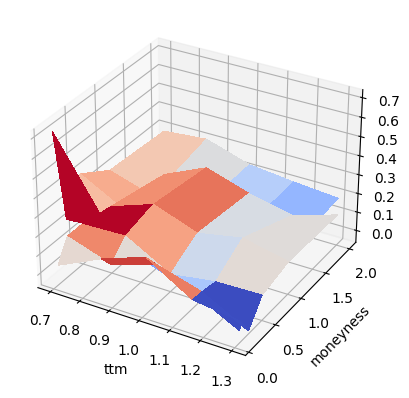

In [21]:
x = torch.from_numpy(data[10].reshape(1, 5, 5)).float().to(model2.device)
y = model2.forward(x).detach().cpu().numpy().reshape((5,5))
plot_surface(data[10], y)

In [22]:
model_conv = VAEConv2D(1, (5, 5), 10, hidden_layer_sizes=[50, 100])
train(model_conv, train_dataloader, test_dataloader, epochs=20, model_dir="test", file_prefix="conv-50-100")

eval: 100%|██████████| 34/34 [00:00<00:00, 755.57it/s]


epoch 0: train loss :: 0.047, dev loss :: 0.093, time elapsed :: 0.4318728446960449


eval: 100%|██████████| 34/34 [00:00<00:00, 467.51it/s]


epoch 1: train loss :: 0.041, dev loss :: 0.087, time elapsed :: 0.41952991485595703


eval: 100%|██████████| 34/34 [00:00<00:00, 485.67it/s]


epoch 2: train loss :: 0.035, dev loss :: 0.079, time elapsed :: 0.4163651466369629


eval: 100%|██████████| 34/34 [00:00<00:00, 549.81it/s]


epoch 3: train loss :: 0.029, dev loss :: 0.071, time elapsed :: 0.4073019027709961


eval: 100%|██████████| 34/34 [00:00<00:00, 509.49it/s]


epoch 4: train loss :: 0.022, dev loss :: 0.062, time elapsed :: 0.3693556785583496


eval: 100%|██████████| 34/34 [00:00<00:00, 619.59it/s]


epoch 5: train loss :: 0.016, dev loss :: 0.054, time elapsed :: 0.45780491828918457


eval: 100%|██████████| 34/34 [00:00<00:00, 647.43it/s]


epoch 6: train loss :: 0.012, dev loss :: 0.049, time elapsed :: 0.41485118865966797


eval: 100%|██████████| 34/34 [00:00<00:00, 643.19it/s]


epoch 7: train loss :: 0.010, dev loss :: 0.047, time elapsed :: 0.37824559211730957


eval: 100%|██████████| 34/34 [00:00<00:00, 697.94it/s]


epoch 8: train loss :: 0.010, dev loss :: 0.045, time elapsed :: 0.42700767517089844


eval: 100%|██████████| 34/34 [00:00<00:00, 435.50it/s]


epoch 9: train loss :: 0.009, dev loss :: 0.045, time elapsed :: 0.4705801010131836


eval: 100%|██████████| 34/34 [00:00<00:00, 520.03it/s]


epoch 10: train loss :: 0.009, dev loss :: 0.044, time elapsed :: 0.4555084705352783


eval: 100%|██████████| 34/34 [00:00<00:00, 579.23it/s]


epoch 11: train loss :: 0.009, dev loss :: 0.044, time elapsed :: 0.47055792808532715


eval: 100%|██████████| 34/34 [00:00<00:00, 753.61it/s]


epoch 12: train loss :: 0.009, dev loss :: 0.044, time elapsed :: 0.35973143577575684


eval: 100%|██████████| 34/34 [00:00<00:00, 737.47it/s]


epoch 13: train loss :: 0.009, dev loss :: 0.044, time elapsed :: 0.3842918872833252


eval: 100%|██████████| 34/34 [00:00<00:00, 606.90it/s]


epoch 14: train loss :: 0.009, dev loss :: 0.043, time elapsed :: 0.4619448184967041


eval: 100%|██████████| 34/34 [00:00<00:00, 658.44it/s]


epoch 15: train loss :: 0.009, dev loss :: 0.043, time elapsed :: 0.4157242774963379


eval: 100%|██████████| 34/34 [00:00<00:00, 693.44it/s]


epoch 16: train loss :: 0.009, dev loss :: 0.043, time elapsed :: 0.41834139823913574


eval: 100%|██████████| 34/34 [00:00<00:00, 617.44it/s]


epoch 17: train loss :: 0.009, dev loss :: 0.043, time elapsed :: 0.4072897434234619


eval: 100%|██████████| 34/34 [00:00<00:00, 675.21it/s]


epoch 18: train loss :: 0.009, dev loss :: 0.043, time elapsed :: 0.3926866054534912


eval: 100%|██████████| 34/34 [00:00<00:00, 755.59it/s]

epoch 19: train loss :: 0.009, dev loss :: 0.043, time elapsed :: 0.3989288806915283
training finished, total time :: 8.359337091445923


In [23]:
model_conv2 = VAEConv2D(1, (5, 5), 10, hidden_layer_sizes=[50, 100])
test(model_conv2, valid_dataloader, test_dataloader, model_dir="test", file_prefix="conv-50-100")

eval: 100%|██████████| 34/34 [00:00<00:00, 655.32it/s]

dev loss: 0.007, test_loss: 0.043


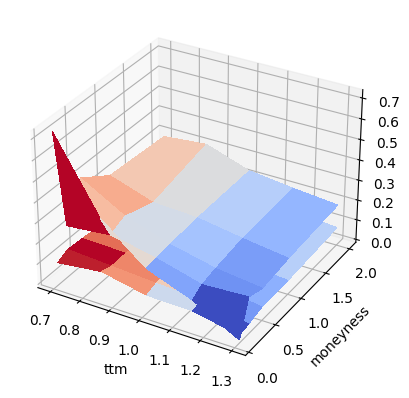

In [24]:
x = torch.from_numpy(data[10].reshape(1, 1, 5, 5)).float().to(model_conv2.device)
y = model_conv2.forward(x).detach().cpu().numpy().reshape((5,5))
plot_surface(data[10], y)

# Test with MINST

In [25]:
class CustomMINST(Dataset):
    def __init__(self, dataset, seq_len):
        self.dataset = dataset.float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.dataset) - self.seq_len + 1

    def __getitem__(self, idx):
        ele = self.dataset[idx:idx+self.seq_len]
        return ele

In [26]:
ds = CustomMINST(datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()).data, 1)
train_loader = DataLoader(ds, batch_size=64, shuffle=True)
ds2 = CustomMINST(datasets.MNIST('data', train=False,
                    transform=transforms.ToTensor()).data, 1)
test_loader = DataLoader(ds2, batch_size=64, shuffle=True)

In [27]:
next(iter(train_loader)).shape

torch.Size([64, 1, 28, 28])

In [28]:
model = VAEDense(1, (28, 28), 256, hidden_layer_sizes=[50, 100])
train(model, train_loader, test_loader, model_dir="MNIST", file_prefix="dense-50-100")

eval: 100%|██████████| 157/157 [00:00<00:00, 1042.19it/s]


epoch 0: train loss :: 8445385162185558016.000, dev loss :: 11345890784418248704.000, time elapsed :: 3.6638152599334717


eval: 100%|██████████| 157/157 [00:00<00:00, 1012.97it/s]


epoch 1: train loss :: 8116651120919011328.000, dev loss :: 10562812054496657408.000, time elapsed :: 3.285727024078369


eval: 100%|██████████| 157/157 [00:00<00:00, 971.01it/s]


epoch 2: train loss :: 7929976491994176512.000, dev loss :: 9894079546076860416.000, time elapsed :: 3.227022886276245


eval: 100%|██████████| 157/157 [00:00<00:00, 920.50it/s]


epoch 3: train loss :: 7784452912330787840.000, dev loss :: 9308481052037875712.000, time elapsed :: 3.653820753097534


eval: 100%|██████████| 157/157 [00:00<00:00, 1039.09it/s]


epoch 4: train loss :: 7648234235315621888.000, dev loss :: 8785188296989788160.000, time elapsed :: 4.578850507736206


eval: 100%|██████████| 157/157 [00:00<00:00, 1001.99it/s]


epoch 5: train loss :: 7465739409119255552.000, dev loss :: 8281392653516446720.000, time elapsed :: 4.080773115158081


eval: 100%|██████████| 157/157 [00:00<00:00, 1061.91it/s]


epoch 6: train loss :: 7341167174524239872.000, dev loss :: 7822625253232925696.000, time elapsed :: 3.3352692127227783


eval: 100%|██████████| 157/157 [00:00<00:00, 929.82it/s]


epoch 7: train loss :: 7204806039010538496.000, dev loss :: 7401929410412406784.000, time elapsed :: 3.280240297317505


eval: 100%|██████████| 157/157 [00:00<00:00, 1043.41it/s]


epoch 8: train loss :: 7097510315318841344.000, dev loss :: 7003939030906018816.000, time elapsed :: 3.3196492195129395


eval: 100%|██████████| 157/157 [00:00<00:00, 1027.19it/s]


epoch 9: train loss :: 6938963953808387072.000, dev loss :: 6612677182673191936.000, time elapsed :: 3.240246057510376


eval: 100%|██████████| 157/157 [00:00<00:00, 1049.03it/s]


epoch 10: train loss :: 6797096357856484352.000, dev loss :: 6274916163223313408.000, time elapsed :: 3.250332832336426


eval: 100%|██████████| 157/157 [00:00<00:00, 990.27it/s]


epoch 11: train loss :: 6686712192758755328.000, dev loss :: 5994609852044473344.000, time elapsed :: 3.3256442546844482


eval: 100%|██████████| 157/157 [00:00<00:00, 1008.34it/s]


epoch 12: train loss :: 6567235562909523968.000, dev loss :: 5636540552493217792.000, time elapsed :: 3.2593514919281006


eval: 100%|██████████| 157/157 [00:00<00:00, 1075.96it/s]


epoch 13: train loss :: 6448411159835040768.000, dev loss :: 5339695318002511872.000, time elapsed :: 3.5487263202667236


eval: 100%|██████████| 157/157 [00:00<00:00, 1108.67it/s]


epoch 14: train loss :: 6344552134373986304.000, dev loss :: 5087226450887914496.000, time elapsed :: 3.1555910110473633


eval: 100%|██████████| 157/157 [00:00<00:00, 1051.94it/s]


epoch 15: train loss :: 6216873585845229568.000, dev loss :: 4835044550554145792.000, time elapsed :: 3.1352550983428955


eval: 100%|██████████| 157/157 [00:00<00:00, 1048.06it/s]


epoch 16: train loss :: 6073016385496425472.000, dev loss :: 4601753160170864640.000, time elapsed :: 3.1167142391204834


eval: 100%|██████████| 157/157 [00:00<00:00, 1040.89it/s]


epoch 17: train loss :: 5958559129978570752.000, dev loss :: 4388059600218774528.000, time elapsed :: 3.123868942260742


eval: 100%|██████████| 157/157 [00:00<00:00, 1140.75it/s]


epoch 18: train loss :: 5825693294822935552.000, dev loss :: 4191829445040360448.000, time elapsed :: 3.1433207988739014


eval: 100%|██████████| 157/157 [00:00<00:00, 1076.51it/s]


epoch 19: train loss :: 5705753708570937344.000, dev loss :: 4000820172228777472.000, time elapsed :: 3.1571593284606934


eval: 100%|██████████| 157/157 [00:00<00:00, 1070.14it/s]


epoch 20: train loss :: 5610217460219264000.000, dev loss :: 3810978542516574720.000, time elapsed :: 3.152384042739868


eval: 100%|██████████| 157/157 [00:00<00:00, 1078.78it/s]


epoch 21: train loss :: 5493393026400751616.000, dev loss :: 3640638104711301120.000, time elapsed :: 3.112291097640991


eval: 100%|██████████| 157/157 [00:00<00:00, 1108.13it/s]


epoch 22: train loss :: 5404738776332365824.000, dev loss :: 3471515161920074240.000, time elapsed :: 3.0920116901397705


eval: 100%|██████████| 157/157 [00:00<00:00, 1068.62it/s]


epoch 23: train loss :: 5294354927364281344.000, dev loss :: 3323143666154214912.000, time elapsed :: 3.1455039978027344


eval: 100%|██████████| 157/157 [00:00<00:00, 1118.01it/s]


epoch 24: train loss :: 5233315375520583680.000, dev loss :: 3180934410186823168.000, time elapsed :: 3.08294939994812


eval: 100%|██████████| 157/157 [00:00<00:00, 1105.34it/s]


epoch 25: train loss :: 5130012547368751104.000, dev loss :: 3043740895298409984.000, time elapsed :: 3.0953686237335205


eval: 100%|██████████| 157/157 [00:00<00:00, 1174.80it/s]


epoch 26: train loss :: 5038145315747945472.000, dev loss :: 2908000062361201152.000, time elapsed :: 3.1789515018463135


eval: 100%|██████████| 157/157 [00:00<00:00, 1170.75it/s]


epoch 27: train loss :: 4935669266829580288.000, dev loss :: 2782927354606548992.000, time elapsed :: 3.0761942863464355


eval: 100%|██████████| 157/157 [00:00<00:00, 948.11it/s]


epoch 28: train loss :: 4829091594539726848.000, dev loss :: 2670516711089714176.000, time elapsed :: 3.6254334449768066


eval: 100%|██████████| 157/157 [00:00<00:00, 993.49it/s]


epoch 29: train loss :: 4760490536425524224.000, dev loss :: 2559896991872030720.000, time elapsed :: 3.280885934829712


eval: 100%|██████████| 157/157 [00:00<00:00, 1041.64it/s]


epoch 30: train loss :: 4663714006099127296.000, dev loss :: 2458717693424818176.000, time elapsed :: 3.295278787612915


eval: 100%|██████████| 157/157 [00:00<00:00, 1101.77it/s]


epoch 31: train loss :: 4592444561955206144.000, dev loss :: 2359135214503881728.000, time elapsed :: 3.395089864730835


eval: 100%|██████████| 157/157 [00:00<00:00, 1007.64it/s]


epoch 32: train loss :: 4479419877540824064.000, dev loss :: 2271246702902268416.000, time elapsed :: 3.305070400238037


eval: 100%|██████████| 157/157 [00:00<00:00, 997.31it/s]


epoch 33: train loss :: 4397141074306507776.000, dev loss :: 2191019795792220672.000, time elapsed :: 3.363358974456787


eval: 100%|██████████| 157/157 [00:00<00:00, 1028.94it/s]


epoch 34: train loss :: 4327951870643167744.000, dev loss :: 2114321800261732352.000, time elapsed :: 3.346766710281372


eval: 100%|██████████| 157/157 [00:00<00:00, 1009.95it/s]


epoch 35: train loss :: 4244039787880790016.000, dev loss :: 2039277471574546432.000, time elapsed :: 3.3773181438446045


eval: 100%|██████████| 157/157 [00:00<00:00, 1040.27it/s]


epoch 36: train loss :: 4197180401045790720.000, dev loss :: 1970036771552645632.000, time elapsed :: 3.453547239303589


eval: 100%|██████████| 157/157 [00:00<00:00, 821.97it/s]


epoch 37: train loss :: 4089016286019310080.000, dev loss :: 1904975509513785344.000, time elapsed :: 3.413257360458374


eval: 100%|██████████| 157/157 [00:00<00:00, 1040.31it/s]


epoch 38: train loss :: 4036315623536628736.000, dev loss :: 1840615033421478912.000, time elapsed :: 3.4185664653778076


eval: 100%|██████████| 157/157 [00:00<00:00, 899.08it/s]


epoch 39: train loss :: 3942341614668149760.000, dev loss :: 1786752290838148352.000, time elapsed :: 3.236565589904785


eval: 100%|██████████| 157/157 [00:00<00:00, 989.32it/s]


epoch 40: train loss :: 3882126840385821696.000, dev loss :: 1753791027165103872.000, time elapsed :: 3.217414617538452


eval: 100%|██████████| 157/157 [00:00<00:00, 1020.42it/s]


epoch 41: train loss :: 3827738900698143232.000, dev loss :: 1667614731777472512.000, time elapsed :: 3.353165864944458


eval: 100%|██████████| 157/157 [00:00<00:00, 1064.63it/s]


epoch 42: train loss :: 3735456931553334272.000, dev loss :: 1614594171847399424.000, time elapsed :: 3.2266154289245605


eval: 100%|██████████| 157/157 [00:00<00:00, 1037.54it/s]


epoch 43: train loss :: 3694890547107831808.000, dev loss :: 1564503252842765056.000, time elapsed :: 3.3066751956939697


eval: 100%|██████████| 157/157 [00:00<00:00, 1041.96it/s]


epoch 44: train loss :: 3613368831029936640.000, dev loss :: 1519427990750133504.000, time elapsed :: 3.2148590087890625


eval: 100%|██████████| 157/157 [00:00<00:00, 971.67it/s]


epoch 45: train loss :: 3539901914455790080.000, dev loss :: 1473878507380688128.000, time elapsed :: 3.1922214031219482


eval: 100%|██████████| 157/157 [00:00<00:00, 1013.80it/s]


epoch 46: train loss :: 3496221250593192960.000, dev loss :: 1432254078551564544.000, time elapsed :: 3.3620736598968506


eval: 100%|██████████| 157/157 [00:00<00:00, 984.22it/s] 


epoch 47: train loss :: 3403644520751685120.000, dev loss :: 1392084854343431168.000, time elapsed :: 3.2806897163391113


eval: 100%|██████████| 157/157 [00:00<00:00, 1071.01it/s]


epoch 48: train loss :: 3356969865943060992.000, dev loss :: 1350539340241076480.000, time elapsed :: 3.332448720932007


eval: 100%|██████████| 157/157 [00:00<00:00, 946.37it/s]


epoch 49: train loss :: 2966205713149949440.000, dev loss :: 1313723817554695680.000, time elapsed :: 3.333960771560669


eval: 100%|██████████| 157/157 [00:00<00:00, 939.72it/s]


epoch 50: train loss :: 2912168630799980032.000, dev loss :: 1278591932308770048.000, time elapsed :: 3.3837976455688477


eval: 100%|██████████| 157/157 [00:00<00:00, 1027.44it/s]


epoch 51: train loss :: 2843827825991220224.000, dev loss :: 1244251088087349504.000, time elapsed :: 3.3641316890716553


eval: 100%|██████████| 157/157 [00:00<00:00, 982.84it/s]


epoch 52: train loss :: 2807465136015500288.000, dev loss :: 1213054943519256320.000, time elapsed :: 3.279846668243408


eval: 100%|██████████| 157/157 [00:00<00:00, 1019.02it/s]


epoch 53: train loss :: 2754105077226095616.000, dev loss :: 1181815191857025536.000, time elapsed :: 3.3400039672851562


eval: 100%|██████████| 157/157 [00:00<00:00, 1005.28it/s]


epoch 54: train loss :: 2703382227706112512.000, dev loss :: 1151712508643455616.000, time elapsed :: 3.3820948600769043


eval: 100%|██████████| 157/157 [00:00<00:00, 1088.25it/s]


epoch 55: train loss :: 2644168016890398208.000, dev loss :: 1122794613811950464.000, time elapsed :: 3.289783239364624


eval: 100%|██████████| 157/157 [00:00<00:00, 1026.23it/s]


epoch 56: train loss :: 2594953695647387648.000, dev loss :: 1095766341867570176.000, time elapsed :: 3.3532419204711914


eval: 100%|██████████| 157/157 [00:00<00:00, 904.35it/s]


epoch 57: train loss :: 2569207347324519424.000, dev loss :: 1069564696123296512.000, time elapsed :: 3.3096530437469482


eval: 100%|██████████| 157/157 [00:00<00:00, 1040.07it/s]


epoch 58: train loss :: 2517636758420305408.000, dev loss :: 1044109483502680960.000, time elapsed :: 3.477018117904663


eval: 100%|██████████| 157/157 [00:00<00:00, 990.37it/s]


epoch 59: train loss :: 2471945191793472000.000, dev loss :: 1019554820193009920.000, time elapsed :: 3.4093716144561768


eval: 100%|██████████| 157/157 [00:00<00:00, 1054.79it/s]


epoch 60: train loss :: 2430961526496930816.000, dev loss :: 996196347701652352.000, time elapsed :: 3.4663360118865967


eval: 100%|██████████| 157/157 [00:00<00:00, 1047.77it/s]


epoch 61: train loss :: 2381551901426732032.000, dev loss :: 973491313312425472.000, time elapsed :: 3.3046836853027344


eval: 100%|██████████| 157/157 [00:00<00:00, 1003.17it/s]


epoch 62: train loss :: 2352028600012452864.000, dev loss :: 951735667146927744.000, time elapsed :: 3.20717716217041


eval: 100%|██████████| 157/157 [00:00<00:00, 998.21it/s]


epoch 63: train loss :: 2298696434113007616.000, dev loss :: 931513830297632000.000, time elapsed :: 3.2737574577331543


eval: 100%|██████████| 157/157 [00:00<00:00, 976.99it/s]


epoch 64: train loss :: 2266952203199627008.000, dev loss :: 910612453673453824.000, time elapsed :: 3.268264055252075


eval: 100%|██████████| 157/157 [00:00<00:00, 1050.80it/s]


epoch 65: train loss :: 2215332834091859200.000, dev loss :: 890948412316966912.000, time elapsed :: 3.2488136291503906


eval: 100%|██████████| 157/157 [00:00<00:00, 988.07it/s]


epoch 66: train loss :: 2174207194204047360.000, dev loss :: 871974056493532544.000, time elapsed :: 3.318896532058716


eval: 100%|██████████| 157/157 [00:00<00:00, 939.39it/s] 


epoch 67: train loss :: 2144846656394790400.000, dev loss :: 853624042456111872.000, time elapsed :: 3.3169822692871094


eval: 100%|██████████| 157/157 [00:00<00:00, 1045.26it/s]


epoch 68: train loss :: 2096574542319429632.000, dev loss :: 835730206914522368.000, time elapsed :: 3.235544204711914


eval: 100%|██████████| 157/157 [00:00<00:00, 993.55it/s]


epoch 69: train loss :: 2076875735930760192.000, dev loss :: 818196720434641920.000, time elapsed :: 3.238662004470825


eval: 100%|██████████| 157/157 [00:00<00:00, 984.62it/s] 


epoch 70: train loss :: 2038030723805789440.000, dev loss :: 801337944689476864.000, time elapsed :: 3.2383501529693604


eval: 100%|██████████| 157/157 [00:00<00:00, 1028.26it/s]


epoch 71: train loss :: 1999259135921765888.000, dev loss :: 785020846967076992.000, time elapsed :: 3.335597038269043


eval: 100%|██████████| 157/157 [00:00<00:00, 940.90it/s]


epoch 72: train loss :: 1959609760222463232.000, dev loss :: 769015558863698432.000, time elapsed :: 3.231863498687744


eval: 100%|██████████| 157/157 [00:00<00:00, 977.76it/s] 


epoch 73: train loss :: 1920091233979561984.000, dev loss :: 753574718101966720.000, time elapsed :: 3.5779459476470947


eval: 100%|██████████| 157/157 [00:00<00:00, 1063.47it/s]


epoch 74: train loss :: 1902049443403629824.000, dev loss :: 738662661088494976.000, time elapsed :: 3.8022401332855225


eval: 100%|██████████| 157/157 [00:00<00:00, 1014.33it/s]


epoch 75: train loss :: 1854450897165664000.000, dev loss :: 724195391539820544.000, time elapsed :: 3.6565322875976562


eval: 100%|██████████| 157/157 [00:00<00:00, 809.07it/s]


epoch 76: train loss :: 1824984844536235776.000, dev loss :: 709757469258654464.000, time elapsed :: 4.043956995010376


eval: 100%|██████████| 157/157 [00:00<00:00, 998.81it/s]


epoch 77: train loss :: 1791439648314852352.000, dev loss :: 695901696908515456.000, time elapsed :: 3.707615852355957


eval: 100%|██████████| 157/157 [00:00<00:00, 956.54it/s] 


epoch 78: train loss :: 1756705978516201728.000, dev loss :: 682410033527156608.000, time elapsed :: 3.3174562454223633


eval: 100%|██████████| 157/157 [00:00<00:00, 1046.47it/s]


epoch 79: train loss :: 1730373782134530560.000, dev loss :: 669319388223635328.000, time elapsed :: 3.253478765487671


eval: 100%|██████████| 157/157 [00:00<00:00, 973.30it/s]


epoch 80: train loss :: 1705580978253230592.000, dev loss :: 656319662631590656.000, time elapsed :: 3.3510775566101074


eval: 100%|██████████| 157/157 [00:00<00:00, 1082.45it/s]


epoch 81: train loss :: 1671786076508531456.000, dev loss :: 643666528727331456.000, time elapsed :: 3.3067667484283447


eval: 100%|██████████| 157/157 [00:00<00:00, 1016.22it/s]


epoch 82: train loss :: 1648616662805640448.000, dev loss :: 631347236942084096.000, time elapsed :: 3.2629313468933105


eval: 100%|██████████| 157/157 [00:00<00:00, 936.50it/s]


epoch 83: train loss :: 1619413041353933056.000, dev loss :: 619277756159913088.000, time elapsed :: 3.3718080520629883


eval: 100%|██████████| 157/157 [00:00<00:00, 948.75it/s]


epoch 84: train loss :: 1589039497770980608.000, dev loss :: 607850967823257728.000, time elapsed :: 3.2862350940704346


eval: 100%|██████████| 157/157 [00:00<00:00, 1063.28it/s]


epoch 85: train loss :: 1563422642884306944.000, dev loss :: 596181710527698688.000, time elapsed :: 3.3855955600738525


eval: 100%|██████████| 157/157 [00:00<00:00, 965.71it/s]


epoch 86: train loss :: 1536156993874781696.000, dev loss :: 584932837154323584.000, time elapsed :: 3.4952497482299805


eval: 100%|██████████| 157/157 [00:00<00:00, 963.21it/s]


epoch 87: train loss :: 1504379089102529792.000, dev loss :: 573690742021799616.000, time elapsed :: 3.4324512481689453


eval: 100%|██████████| 157/157 [00:00<00:00, 1002.74it/s]


epoch 88: train loss :: 1479746467514592768.000, dev loss :: 563261420668010176.000, time elapsed :: 3.6892337799072266


eval: 100%|██████████| 157/157 [00:00<00:00, 1097.57it/s]


epoch 89: train loss :: 1453325288713183232.000, dev loss :: 552799066797020160.000, time elapsed :: 3.5104596614837646


eval: 100%|██████████| 157/157 [00:00<00:00, 982.79it/s]


epoch 90: train loss :: 1429952084563607296.000, dev loss :: 542615324689297408.000, time elapsed :: 3.407426118850708


eval: 100%|██████████| 157/157 [00:00<00:00, 1039.19it/s]


epoch 91: train loss :: 1399447379082779904.000, dev loss :: 532647108999862208.000, time elapsed :: 3.273550033569336


eval: 100%|██████████| 157/157 [00:00<00:00, 1065.48it/s]


epoch 92: train loss :: 1375558425309958656.000, dev loss :: 522907685265294016.000, time elapsed :: 3.230950355529785


eval: 100%|██████████| 157/157 [00:00<00:00, 1068.29it/s]


epoch 93: train loss :: 1352722905450514688.000, dev loss :: 513293104306546176.000, time elapsed :: 3.281766653060913


eval: 100%|██████████| 157/157 [00:00<00:00, 995.01it/s]


epoch 94: train loss :: 1335867991258544128.000, dev loss :: 500069141391184704.000, time elapsed :: 3.2371113300323486


eval: 100%|██████████| 157/157 [00:00<00:00, 997.77it/s]


epoch 95: train loss :: 1314412375876453632.000, dev loss :: 478451633140496768.000, time elapsed :: 3.3052241802215576


eval: 100%|██████████| 157/157 [00:00<00:00, 974.52it/s]


epoch 96: train loss :: 1284273152907831040.000, dev loss :: 458852928011931776.000, time elapsed :: 3.387242555618286


eval: 100%|██████████| 157/157 [00:00<00:00, 1022.22it/s]


epoch 97: train loss :: 1260595819607532800.000, dev loss :: 445545409411782272.000, time elapsed :: 3.270432472229004


eval: 100%|██████████| 157/157 [00:00<00:00, 1063.98it/s]


epoch 98: train loss :: 1238734862241044224.000, dev loss :: 430568178963977600.000, time elapsed :: 3.3738999366760254


eval: 100%|██████████| 157/157 [00:00<00:00, 965.90it/s]

epoch 99: train loss :: 1214325076835584512.000, dev loss :: 405140546319352256.000, time elapsed :: 3.2572858333587646
training finished, total time :: 334.9129922389984


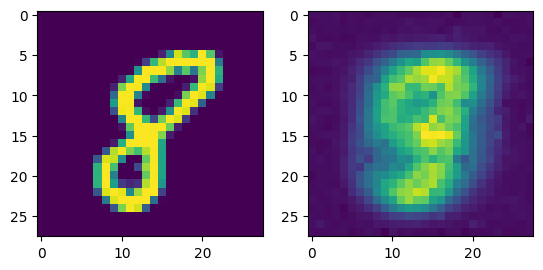

In [29]:
x = random.sample(list(test_loader), 1)[0][0] # 1x28x28
y = model(x.to(model.device)).detach().cpu().numpy()[0]
img1 = np.transpose(x.numpy(), [1, 2, 0])
img2 = np.transpose(y, [1, 2, 0])
plt.subplot(121)
plt.imshow(np.squeeze(img1))
plt.subplot(122)
plt.imshow(np.squeeze(img2))

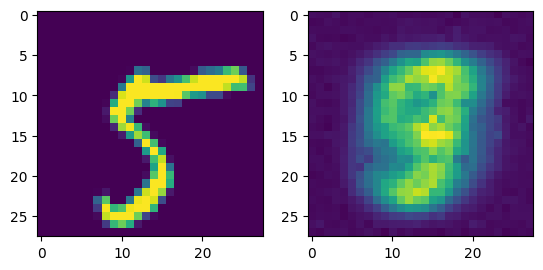

In [30]:
x = random.sample(list(test_loader), 1)[0][0] # 1x28x28
y = model(x.to(model.device)).detach().cpu().numpy()[0]
img1 = np.transpose(x.numpy(), [1, 2, 0])
img2 = np.transpose(y, [1, 2, 0])
plt.subplot(121)
plt.imshow(np.squeeze(img1))
plt.subplot(122)
plt.imshow(np.squeeze(img2))

In [31]:
model = VAEConv2D(1, (28, 28), 256, hidden_layer_sizes=[50, 100])
train(model, train_loader, test_loader, model_dir="MNIST", file_prefix="conv-50-100", epochs=10)

eval: 100%|██████████| 157/157 [00:00<00:00, 218.70it/s]


epoch 0: train loss :: 5995.123, dev loss :: 4320.758, time elapsed :: 26.732832193374634


eval: 100%|██████████| 157/157 [00:00<00:00, 224.38it/s]


epoch 1: train loss :: 3594.682, dev loss :: 2935.015, time elapsed :: 26.51429796218872


eval: 100%|██████████| 157/157 [00:00<00:00, 223.22it/s]


epoch 2: train loss :: 2482.266, dev loss :: 2124.577, time elapsed :: 26.5229012966156


eval: 100%|██████████| 157/157 [00:00<00:00, 217.24it/s]


epoch 3: train loss :: 1941.675, dev loss :: 1761.642, time elapsed :: 26.684330224990845


eval: 100%|██████████| 157/157 [00:00<00:00, 219.29it/s]


epoch 4: train loss :: 1659.480, dev loss :: 1524.330, time elapsed :: 26.785502672195435


eval: 100%|██████████| 157/157 [00:00<00:00, 219.41it/s]


epoch 5: train loss :: 1451.790, dev loss :: 1365.500, time elapsed :: 26.60738253593445


eval: 100%|██████████| 157/157 [00:00<00:00, 216.48it/s]


epoch 6: train loss :: 1272.029, dev loss :: 1169.513, time elapsed :: 26.49039888381958


eval: 100%|██████████| 157/157 [00:00<00:00, 218.54it/s]


epoch 7: train loss :: 1116.969, dev loss :: 1030.387, time elapsed :: 26.525253772735596


eval: 100%|██████████| 157/157 [00:00<00:00, 217.95it/s]


epoch 8: train loss :: 989.748, dev loss :: 916.050, time elapsed :: 26.960748434066772


eval: 100%|██████████| 157/157 [00:00<00:00, 213.61it/s]


epoch 9: train loss :: 887.193, dev loss :: 827.128, time elapsed :: 26.61375141143799
training finished, total time :: 266.43930864334106


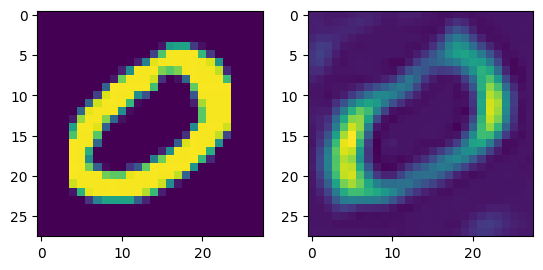

In [32]:
x = random.sample(list(test_loader), 1)[0][0:1] # 1x1x28x28
y = model(x.to(model.device)).detach().cpu().numpy()[0]
img1 = np.transpose(x.numpy()[0], [1, 2, 0])
img2 = np.transpose(y, [1, 2, 0])
plt.subplot(121)
plt.imshow(np.squeeze(img1))
plt.subplot(122)
plt.imshow(np.squeeze(img2))

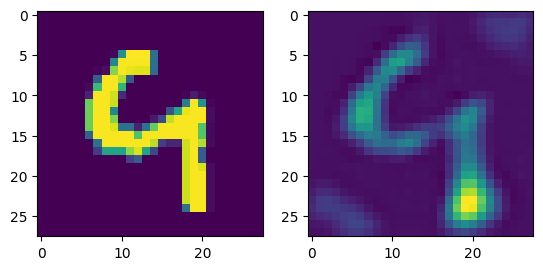

In [33]:
x = random.sample(list(test_loader), 1)[0][0:1] # 1x1x28x28
y = model(x.to(model.device)).detach().cpu().numpy()[0]
img1 = np.transpose(x.numpy()[0], [1, 2, 0])
img2 = np.transpose(y, [1, 2, 0])
plt.subplot(121)
plt.imshow(np.squeeze(img1))
plt.subplot(122)
plt.imshow(np.squeeze(img2))